In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os
import copy
from collections import defaultdict

/Users/lukebailey/opt/miniconda3/envs/misc/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Helper Funcs
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def train_resnet(
    model, 
    criterion, 
    optimizer, 
    scheduler, 
    dataloaders, 
    device, 
    dataset_sizes,
    num_epochs=25
):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    timing_data = defaultdict(list)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for minibatch_num, (inputs, labels) in enumerate(dataloaders[phase]):

                start = time.time()

                if minibatch_num % 1000 == 0:
                    print(f'Minibatch {minibatch_num}')

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                end = time.time()

                if phase == 'train':
                    timing_data[epoch].append(end - start)


            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, timing_data




In [26]:
# The output of torchvision datasets are PILImage images of range [0, 1]. 
# Transform them to Tensors of normalized range [-1, 1].

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

dataloaders = {
    'train': trainloader, 
    'val': testloader
}
dataset_sizes = {
    'train' : len(trainloader),
    'test' : len(testloader)
}

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


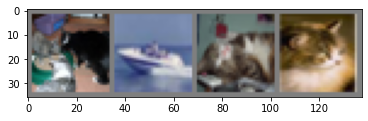

['cat', 'ship', 'cat', 'cat']


In [17]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print([classes[labels[i]] for i in  range(batch_size)])

In [29]:
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(classes))

model_ft = model_ft.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/Users/lukebailey/opt/miniconda3/envs/misc/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lukebailey/opt/miniconda3/envs/misc/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [32]:
model_ft = train_model(
    model_ft, 
    criterion, 
    optimizer_ft, 
    exp_lr_scheduler,
    dataloaders, 
    DEVICE, 
    dataset_sizes,
    num_epochs=1
)

Epoch 0/0
----------
Minibatch 0
Minibatch 10
Minibatch 20
Minibatch 30
Minibatch 40
Minibatch 50
Minibatch 60
Minibatch 70
Minibatch 80
Minibatch 90
Minibatch 100
Minibatch 110
Minibatch 120
Minibatch 130
Minibatch 140
Minibatch 150
Minibatch 160
Minibatch 170
Minibatch 180
Minibatch 190
Minibatch 200
Minibatch 210
Minibatch 220
Minibatch 230
Minibatch 240
Minibatch 250
Minibatch 260
Minibatch 270
Minibatch 280
Minibatch 290
Minibatch 300
Minibatch 310
Minibatch 320
Minibatch 330
Minibatch 340


KeyboardInterrupt: 

In [33]:
len(trainloader)

12500

# Cleaning Up Code

In [82]:
def get_cfar_dataset(trainset_size=None):

    # The output of torchvision datasets are PILImage images of range [0, 1]. 
    # Transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    batch_size = 4

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)

    if trainset_size is not None:
        trainset = [trainset[i] for i in range(trainset_size)]

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

    dataloaders = {
        'train': trainloader, 
        'val': testloader
    }
    dataset_sizes = {
        'train' : len(trainloader),
        'val' : len(testloader)
    }

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    return dataloaders, dataset_sizes, classes

def get_resnet_and_optimizer(classes):

    model_ft = models.resnet18(pretrained=False)
    num_ftrs = model_ft.fc.in_features
    # Here the size of each output sample is set to 2.
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    model_ft.fc = nn.Linear(num_ftrs, len(classes))

    model_ft = model_ft.to(DEVICE)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    return  model_ft, criterion, optimizer_ft, exp_lr_scheduler

    

def collect_timing_data_resnet():

    # Get datasset
    print("Collecting CFAR dataset")
    dataloaders, dataset_sizes, classes = get_cfar_dataset(2000)

    print(len(dataloaders['train']))

    # Get model and training infrastructure
    print("Instantiating resnet")
    model, criterion, optimizer, scheduler = get_resnet_and_optimizer(classes)

    
    # Train and time
    print("Training ResNet")
    model, timing_data = train_resnet(
        model, 
        criterion, 
        optimizer, 
        scheduler,
        dataloaders, 
        DEVICE, 
        dataset_sizes,
        num_epochs=1
    )

    return model, timing_data 


In [83]:
model, timing_data = collect_timing_data_resnet()

Files already downloaded and verified
Files already downloaded and verified
500
Instantiating resnet
Training ResNet
Epoch 0/0
----------


/Users/lukebailey/opt/miniconda3/envs/misc/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lukebailey/opt/miniconda3/envs/misc/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Minibatch 0
train Loss: 10.3317 Acc: 0.6800
Minibatch 0
Minibatch 1000
Minibatch 2000
val Loss: 9.3340 Acc: 0.8848

Training complete in 0m 46s
Best val Acc: 0.884800


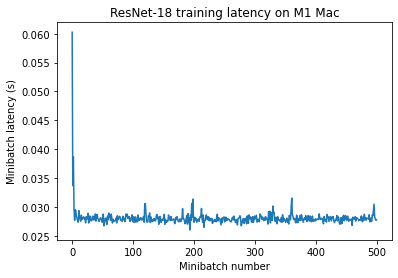

In [89]:
epoch_0 = timing_data[0]
plt.ylabel("Minibatch latency (s)")
plt.xlabel("Minibatch number")
plt.title("ResNet-18 training latency on M1 Mac")
plt.plot([i for i in range(len(epoch_0))], epoch_0)
plt.savefig("./training.png")

In [87]:
timing_data[0]

[0.06024909019470215,
 0.033677101135253906,
 0.038655996322631836,
 0.029799938201904297,
 0.027666091918945312,
 0.029517173767089844,
 0.02938699722290039,
 0.028348922729492188,
 0.028022050857543945,
 0.027597904205322266,
 0.02735424041748047,
 0.029356002807617188,
 0.028100967407226562,
 0.02786397933959961,
 0.02752995491027832,
 0.02859807014465332,
 0.027845144271850586,
 0.02815723419189453,
 0.02813577651977539,
 0.028287887573242188,
 0.027855873107910156,
 0.0280759334564209,
 0.027246713638305664,
 0.028304100036621094,
 0.02788686752319336,
 0.028092145919799805,
 0.028910160064697266,
 0.027211904525756836,
 0.027675867080688477,
 0.028437137603759766,
 0.027644872665405273,
 0.027785062789916992,
 0.027595996856689453,
 0.028304100036621094,
 0.02841496467590332,
 0.02777695655822754,
 0.02830219268798828,
 0.027755022048950195,
 0.02878284454345703,
 0.0275421142578125,
 0.028434038162231445,
 0.02871108055114746,
 0.027981042861938477,
 0.027864694595336914,
 0.027

# BERT on CoLA

In [16]:
import logging
import os
import random
import sys
from dataclasses import dataclass, field
from typing import Optional

import datasets
import numpy as np
from datasets import load_dataset

import transformers
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    PretrainedConfig,
    Trainer,
    TrainingArguments,
    default_data_collator,
    set_seed,
)
from transformers.trainer_utils import get_last_checkpoint
from transformers.utils import check_min_version, send_example_telemetry
from transformers.utils.versions import require_version
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

In [9]:
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

raw_datasets = load_dataset(
    "glue",
    "cola",
    cache_dir="./data",
    #use_auth_token=True if model_args.use_auth_token else None,
)




Found cached dataset glue (/Users/lukebailey/Documents/classes/junior_year/fall_2022/CS243/final_project/hungry_hungry_ps/training_latency_eval/./data/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 3/3 [00:00<00:00, 934.28it/s]


In [11]:
raw_datasets.keys()
raw_datasets['train'][0]

{'sentence': "Our friends won't buy this analysis, let alone the next one we propose.",
 'label': 1,
 'idx': 0}

In [18]:

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

train_input_ids = []
train_input_mask = []
labels = []

# Tokenize all of the sentences and map the tokens to thier word IDs.
# For every sentence...
for sent in raw_datasets['train']:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent['sentence'],                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    train_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    train_input_mask.append(encoded_dict['attention_mask'])

    labels.append(sent['label'])

# Convert the lists into tensors.
input_ids = torch.cat(train_input_ids, dim=0)
attention_masks = torch.cat(train_input_mask, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', raw_datasets['train'][0]['sentence'])
print('Token IDs:', train_input_ids[0])

train_dataset = TensorDataset(input_ids, attention_masks, labels)

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

Loading BERT tokenizer...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: tensor([[  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
          2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]])


In [19]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
)

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [24]:
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [33]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# For each epoch...
model.to(DEVICE)
epochs = 1
timing_dataset = []
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    #print("")
    #print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    #print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        start = time.time()
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(DEVICE)
        b_input_mask = batch[1].to(DEVICE)
        b_labels = batch[2].to(DEVICE)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        #total_train_loss += loss.item()
        loss = outputs[0]
        total_train_loss += loss

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

        end = time.time()
        timing_dataset.append(end - start)

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

  Batch    40  of    268.    Elapsed: 0:01:32.
  Batch    80  of    268.    Elapsed: 0:02:47.
  Batch   120  of    268.    Elapsed: 0:04:04.
  Batch   160  of    268.    Elapsed: 0:05:25.
  Batch   200  of    268.    Elapsed: 0:06:47.
  Batch   240  of    268.    Elapsed: 0:08:17.

  Average training loss: 0.48
  Training epcoh took: 0:09:10


In [32]:
print(len(train_dataloader))

268


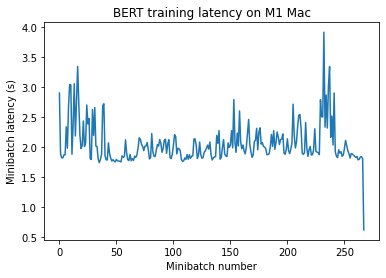

In [36]:
epoch_0 = timing_dataset
plt.ylabel("Minibatch latency (s)")
plt.xlabel("Minibatch number")
plt.title("BERT training latency on M1 Mac")
plt.plot([i for i in range(len(epoch_0))], epoch_0)
plt.savefig("./training.png")

## CLeaning up BERT on CoLA

In [37]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def get_cola_dataset():

    raw_datasets = load_dataset(
        "glue",
        "cola",
        cache_dir="./data",
        #use_auth_token=True if model_args.use_auth_token else None,
    )

    # Load the BERT tokenizer.
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

    train_input_ids = []
    train_input_mask = []
    labels = []

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    # For every sentence...
    for sent in raw_datasets['train']:
        encoded_dict = tokenizer.encode_plus(
                            sent['sentence'],                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 64,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                    )
        # Add the encoded sentence to the list.    
        train_input_ids.append(encoded_dict['input_ids'])
        # And its attention mask (simply differentiates padding from non-padding).
        train_input_mask.append(encoded_dict['attention_mask'])
        labels.append(sent['label'])
    # Convert the lists into tensors.
    input_ids = torch.cat(train_input_ids, dim=0)
    attention_masks = torch.cat(train_input_mask, dim=0)
    labels = torch.tensor(labels)
    train_dataset = TensorDataset(input_ids, attention_masks, labels)

    # The DataLoader needs to know our batch size for training, so we specify it 
    # here. For fine-tuning BERT on a specific task, the authors recommend a batch 
    # size of 16 or 32.
    batch_size = 32

    train_dataloader = DataLoader(
                train_dataset,  # The training samples.
                sampler = RandomSampler(train_dataset), # Select batches randomly
                batch_size = batch_size # Trains with this batch size.
    )

    return train_dataloader 

def get_bert_and_optimizer():

    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 2, # The number of output labels--2 for binary classification.
                        # You can increase this for multi-class tasks.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

    optimizer = AdamW(model.parameters(),
                    lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                    eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
    )

    # Get timing data for 1 epoch
    epochs = 1
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)

    return  model, optimizer, scheduler


def finetune_BERT(
    model, 
    optimizer, 
    scheduler, 
    train_dataloader, 
    num_epochs=1
):


    # For each epoch...
    model.to(DEVICE)
    timing_dataset = []
    for epoch in range(0, num_epochs):
        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode. Don't be mislead--the call to 
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)
                
                # Report progress.
                print(f'Batch {step} of {len(train_dataloader)}')

            start = time.time()
            b_input_ids = batch[0].to(DEVICE)
            b_input_mask = batch[1].to(DEVICE)
            b_labels = batch[2].to(DEVICE)

            # Always clear any previously calculated gradients
            model.zero_grad()        

            # outputs = (loss, logits)
            outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels)

            loss = outputs[0]
            total_train_loss += loss

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            end = time.time()
            timing_dataset.append(end - start)

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            
        
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        
    return timing_dataset
        

def collect_timing_data_BERT():

    # Get datasset
    print("Collecting CoLA dataset")
    train_dataloader = get_cola_dataset()

    # Get model and training infrastructure
    print("Instantiating BERT")
    model, optimizer, scheduler = get_bert_and_optimizer()

    # Train and time
    print("Finetuning BERT")
    timing_data = finetune_BERT(
        model, 
        optimizer, 
        scheduler,
        train_dataloader, 
        num_epochs=1
    )

    return timing_data 

In [41]:
timing_data = collect_timing_data_BERT()

Found cached dataset glue (/Users/lukebailey/Documents/classes/junior_year/fall_2022/CS243/final_project/hungry_hungry_ps/training_latency_eval/./data/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 3/3 [00:00<00:00, 858.55it/s]
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/lukebailey/opt/miniconda3/envs/misc/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to 

Instantiating BERT


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Finetuning BERT
Batch 40 of 268
Batch 80 of 268
Batch 120 of 268
Batch 160 of 268
Batch 200 of 268
Batch 240 of 268

  Average training loss: 0.49


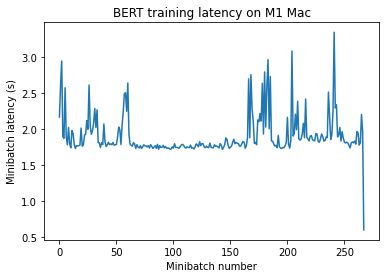

In [42]:
epoch_0 = timing_data
plt.ylabel("Minibatch latency (s)")
plt.xlabel("Minibatch number")
plt.title("BERT training latency on M1 Mac")
plt.plot([i for i in range(len(epoch_0))], epoch_0)
plt.savefig("./training.png")

In [43]:
print(np.array(timing_data).mean())

1.905683869746194
